# Tarea 5 Procesamiento Avanzado de Imagenes: Redes convolucionales.

 `Diego Irarrazaval` 

## Introduccion:
Las redes convolucionales son un algoritmo de DeepLearning muy utilizado para el procesamiento de imagenes y vision computacional. Inspiradas po la corteza visual del cerebro, las redes convolucionales (o equivalentemente CNN) reciben imagenes e intentan, a travez de un proceso de entrenamiento de ajuste de parametros, ser capaces de clasificar/diferenciar estas. 

La unidad basica de estas redes corresponde a la convolucion, operacion que se ha visto en repetidas ocaciones a lo largo del curso, por lo que no se entrara en mayor detalle. 

En el ultimo tiempo, acompanado por los avances computacionales que permiten implementar redes cada vez mas complejas, las CNN han logrado resolver problemas cada vez mas complejos. 

La primera CNN 'famosa', la LeNet-5 [GradientBased Learning Applied to Document Recognition](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf), era una red (muy simple para lo que se implementa hoy) cuyo objetivo era resolver el problema de identificar simbolos escritos a mano. La arquitectura se muestra a continuacin:

![Arquitectura LeNet-5](lenet5.png)

En la imagen se aprecia que la arquitectura es bastante simple (en comparacion a lo que se implementara en la tarea). 

La siguiente arquitectura (combinacion de capas) que significo un cambio importante corresponde a la `AlexNet`. Esta red, fue la primera CNN en superar metodos clasicos de vision computacional en el problema visto en clases de `ImageNet`. 

Otros avances importantes corresponden a la implementacion de modulos `Inception`, por ejemplo en la `GoogleNet` ([Going deeper with convolutions](https://arxiv.org/pdf/1409.4842v1.pdf)):    

![Inception Module](inception.png)

En la imagen se observa el bloque `Inception`, uno de los modulos de la `GoogLeNet`. Para ver la arquitectura completa, visitar el link anteriormente puesto. 

El estado del arte corresponde no solo a redes mas grandes sino tambien a otras formas de entrenar: distintos optimizadores, etc, que hacen que la red converga mas rapido a los minimos en la funcion de perdida. 

Por ejemplo, en el siguiente ranking [CIFAR10 Benchmark](https://paperswithcode.com/sota/image-classification-on-cifar-10), el paper que ocupa el primer lugar ([Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/pdf/2010.01412v2.pdf) no propone una nueva arquitectura sino un nuevo optimizador para el entrenamiento. 


## Sobre el problema a resolver:

El objetivo de esta tarea, es implementar una (dos, una grande y una pequena) CNN que resuelva el problema conocido como CIFAR10 y ademas familiarizase con Pytorch. Este dataset correspode a 60000 imagenes de 32x32 a color (es decir, `[3, 32, 32]`, de 10 clases distintas, con 6000 imagenes por clase. 

![Problema CIFAR10](cifar10.png)

En la imagen anterior se muestran las clases y ejemplos de las imagenes del dataset. 

## Siguientes secciones:
En las siguientes secciones se muestran la implementacion de las dos arquitecturas solicitadas en el enunciado. Luego de cada implementacion, se prueba que esta sea correcta con una herramienta llamada `torchsummary`. 

Luego de implementar las CNN's, se implementa la clase `CIFAR10dataset` solicitada. 

Finalmente se entrena cada red y se realizan experimentos para intentar mejorar el desempeno. 

Es importante destacar que para el entrenamiento se utilizan dos funciones recicladas de otra ocacion que se encuentran en el siguiente repositorio: [Procesamiento Avanzado de Imagenes, Diego I, GitHub](https://github.com/Diego-II/Procesamiento-Avanzado-de-Imagenes/blob/master/utils/utils.py).

In [1]:
import os
import sys
import random
import pickle

from timeit import default_timer as timer

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

# Algunas cosas para graficar matrices de confusion
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torchvision
import torchvision.transforms as transforms

!pip install torchsummary
from torchsummary import summary

# Importamos un par de funciones que hice pa entrenar y graficar
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/Diego-II/Procesamiento-Avanzado-de-Imagenes/master/utils/utils.py
from utils import *

--2020-12-15 02:45:31--  https://raw.githubusercontent.com/Diego-II/Procesamiento-Avanzado-de-Imagenes/master/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6265 (6.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.12K  --.-KB/s    in 0s      

2020-12-15 02:45:31 (96.3 MB/s) - ‘utils.py’ saved [6265/6265]



# Arquitectura Pequena:
Primero se implementara la arquitectura pequena. Para esto se dividiran en sub-bloques que se usaran en toda la tarea. Por ejemplo `Conv2dReluBn` corresponde a una capa convolucional con funcion de activacion `Relu` y `Batch Normalization`. 

## SubModulos:

In [2]:
class Conv2dReBn(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size = 3,
      bias = False,
      padding = 1,
      **kwargs
  ):
    super(Conv2dReBn, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.bias = bias
    self.padding = padding
    self.Conv2dReBn = nn.Sequential(
          nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=self.kernel_size, bias = self.bias, padding=self.padding, **kwargs),
          nn.ReLU(),
          nn.BatchNorm2d(self.out_channels)
    )

  def forward(self, x):
    return self.Conv2dReBn(x)

In [3]:
test_capa = True
if test_capa:
  device = 'cuda'
  # Instanciamos la red
  test_model = Conv2dReBn(3, 3).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              81
              ReLU-2            [-1, 3, 32, 32]               0
       BatchNorm2d-3            [-1, 3, 32, 32]               6
Total params: 87
Trainable params: 87
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


Tambien implementaremos el modulo `LinearReBn` que corresponde a una capa `Fully Conected` + `ReLu` + `BatchNormalization`:

In [4]:
class LinearReBn(nn.Module):
  def __init__(
      self, 
      in_features,
      out_features
  ):
    super(LinearReBn, self).__init__()
    self.LinearReBn = nn.Sequential(OrderedDict([
        ('Linear', nn.Linear(in_features=in_features, out_features=out_features)),
        ('ReLu', nn.ReLU()),
        ('BatchNorm', nn.BatchNorm1d(num_features=out_features))
    ]))

  def forward(self, x):
    return self.LinearReBn(x)

Vamos ahora con la Red Pequena:

In [5]:
# clase para debugear:
class Print(nn.Module):
  def forward(self, x):
    print('Tamano de x  = {}.'.format(x.size()))
    return x

In [6]:
class MyNetSmall(nn.Module):
  def __init__(
      self,
      n_classes = 10
  ):
    super(MyNetSmall, self).__init__()
    self.n_classes = n_classes  
    # Cuerpo de la red:
    self.body = nn.Sequential(OrderedDict([
        ('Conv2d_1', Conv2dReBn(3, 64, kernel_size=3, padding=1, stride=1)),
        ('MaxPool_1', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ('Conv2d_2', Conv2dReBn(64, 128, kernel_size=3, padding=1, stride=1)),
        ('MaxPool_2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ('Conv2d_3', Conv2dReBn(128, 256, kernel_size=3, padding=1, stride=1)),
        ('MaxPool_3', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ('Conv2d_4', Conv2dReBn(256, 512, kernel_size=3, padding=1, stride=1)),
        ('MaxPool_4', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        # ('Debugger1', Print()),
    ]))
    self.classification = nn.Sequential(OrderedDict([
        # ('Flatten', nn.Flatten(1,3)),
        # ('Debugger2', Print()),
        ('FullyConected1', LinearReBn(in_features=2048, out_features=128)),
        ('FullyConected2', nn.Linear(in_features=128, out_features=n_classes))
    ]))
    
  def forward(self, x):
    x = self.body(x)
    x = self.classification(torch.flatten(x,1,3))
    return x

In [7]:
test_capa = True
if test_capa:
  device = 'cuda'
  # Instanciamos la red
  test_model = MyNetSmall(10).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
        Conv2dReBn-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,728
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
        Conv2dReBn-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         294,912
             ReLU-12            [-1, 256, 8, 8]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
       Conv2dReBn-14            [-1, 25

In [8]:
test_model.parameters

<bound method Module.parameters of MyNetSmall(
  (body): Sequential(
    (Conv2d_1): Conv2dReBn(
      (Conv2dReBn): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (MaxPool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_2): Conv2dReBn(
      (Conv2dReBn): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (MaxPool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3): Conv2dReBn(
      (Conv2dReBn): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): Batc

# Implementacion de `MyNetBig`:

In [9]:
class MyNetBig(nn.Module):
  def __init__(
      self,
      n_classes = 10
  ):
    super(MyNetBig, self).__init__()
    self.n_classes = n_classes  
    # Cuerpo de la red:
    self.body = nn.Sequential(OrderedDict([
        ('Conv2d_1', nn.Sequential(
            Conv2dReBn(3, 64, kernel_size=3, padding=1, stride=1),
            Conv2dReBn(64, 64, kernel_size=3, padding=1, stride=1))
        ),

        ('MaxPool_1', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),

        ('Conv2d_2', nn.Sequential(
            Conv2dReBn(64, 128, kernel_size=3, padding=1, stride=1),
            Conv2dReBn(128, 128, kernel_size=3, padding=1, stride=1))
        ),

        ('MaxPool_2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),

        ('Conv2d_3', nn.Sequential(
            Conv2dReBn(128, 256, kernel_size=3, padding=1, stride=1),
            Conv2dReBn(256, 256, kernel_size=3, padding=1, stride=1))
        ),

        ('MaxPool_3', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        
        ('Conv2d_4', nn.Sequential(
            Conv2dReBn(256, 512, kernel_size=3, padding=1, stride=1),
            Conv2dReBn(512, 512, kernel_size=3, padding=1, stride=1))
        ),
        ('MaxPool_4', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        # ('Debugger1', Print()),
    ]))
    self.classification = nn.Sequential(OrderedDict([
        # ('Debugger2', Print()),
        ('FullyConected1', LinearReBn(in_features=2048, out_features=1024)),
        ('FullyConected2', LinearReBn(in_features=1024, out_features=512)),
        ('FullyConected3', LinearReBn(in_features=512, out_features=256)),
        ('FullyConected4', LinearReBn(in_features=256, out_features=128)),
        ('FullyConected5', nn.Linear(in_features=128, out_features=n_classes))
    ]))
  def forward(self, x):
    x = self.body(x)
    x = self.classification(torch.flatten(x,1,3))
    return x

In [10]:
test_capa = True
if test_capa:
  device = 'cuda'
  # Instanciamos la red
  test_model = MyNetBig(10).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
        Conv2dReBn-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        Conv2dReBn-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,728
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       Conv2dReBn-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [11]:
test_model.parameters

<bound method Module.parameters of MyNetBig(
  (body): Sequential(
    (Conv2d_1): Sequential(
      (0): Conv2dReBn(
        (Conv2dReBn): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv2dReBn(
        (Conv2dReBn): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (MaxPool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_2): Sequential(
      (0): Conv2dReBn(
        (Conv2dReBn): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU()
          (2): BatchNorm2d(128, eps=1

# DataSet Cifar10:

In [12]:
# descarga y descompresion de dataset:
if not os.path.exists("cifar-10-python.tar.gz"):
  !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !tar -xvf '/content/cifar-10-python.tar.gz' -C '/content/'

--2020-12-15 02:45:42--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  91.7MB/s    in 1.8s    

2020-12-15 02:45:44 (91.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [13]:
from PIL import Image
class CIFAR10Train(Dataset):
  def __init__(self, path = '/content/cifar-10-batches-py/', transform= None, dataset_completo = False):
    super(CIFAR10Train, self).__init__()
    self. transform = transform
    self.path = path
    
    if dataset_completo:
      paths = ['data_batch_1', 'data_batch_3', 'data_batch_4', 'data_batch_5']    
    else:
      paths = ['data_batch_1']

    self.data = []
    self.targets = []
    for p in paths:
      file_path = os.path.join(self.path, p)
      with open(file_path, 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        self.data.append(entry['data'])
        if 'labels' in entry:
            self.targets.extend(entry['labels'])
        else:
            self.targets.extend(entry['fine_labels'])
    self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
    self.data = self.data.transpose((0, 2, 3, 1))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    img, target = self.data[index], self.targets[index]
    img = Image.fromarray(img)
    if self.transform is not None:
      img = self.transform(img)

    return img, target

In [14]:
datatrain = CIFAR10Train()

In [15]:
img, target = datatrain[0]

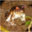

In [16]:
img

In [17]:
target

6

In [18]:
from PIL import Image
class CIFAR10Val(Dataset):
  def __init__(self, path = '/content/cifar-10-batches-py/', transform= None):
    super(CIFAR10Val, self).__init__()
    self. transform = transform
    self.path = path

    paths = ['data_batch_2']

    self.data = []
    self.targets = []
    for p in paths:
      file_path = os.path.join(self.path, p)
      with open(file_path, 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        self.data.append(entry['data'])
        if 'labels' in entry:
            self.targets.extend(entry['labels'])
        else:
            self.targets.extend(entry['fine_labels'])
    self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
    self.data = self.data.transpose((0, 2, 3, 1))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    img, target = self.data[index], self.targets[index]
    img = Image.fromarray(img)
    if self.transform is not None:
      img = self.transform(img)

    return img, target

In [19]:
from PIL import Image
class CIFAR10Test(Dataset):
  def __init__(self, path = '/content/cifar-10-batches-py/', transform= None):
    super(CIFAR10Test, self).__init__()
    self. transform = transform
    self.path = path

    paths = ['test_batch']

    self.data = []
    self.targets = []
    for p in paths:
      file_path = os.path.join(self.path, p)
      with open(file_path, 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        self.data.append(entry['data'])
        if 'labels' in entry:
            self.targets.extend(entry['labels'])
        else:
            self.targets.extend(entry['fine_labels'])
    self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
    self.data = self.data.transpose((0, 2, 3, 1))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    img, target = self.data[index], self.targets[index]
    img = Image.fromarray(img)
    if self.transform is not None:
      img = self.transform(img)

    return img, target

# Entrenamiento con los dataset cargados con la clase creada:

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10Train(transform=transform)

testset = CIFAR10Test(transform=transform)

valset = CIFAR10Val(transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Entrenamiento BigNet:
Entrenamiento de la red grande con el dataset creado y las herramientas importadas anteriormente:

Epoch:1(10000/10000), Loss:1.87997, Train Acc:28.8%, Validating..., Val Acc:35.29%, Avg-Time:6.673s.
Epoch:2(10000/10000), Loss:1.61147, Train Acc:40.4%, Validating..., Val Acc:43.36%, Avg-Time:6.656s.
Epoch:3(10000/10000), Loss:1.42154, Train Acc:48.2%, Validating..., Val Acc:50.68%, Avg-Time:6.597s.
Epoch:4(10000/10000), Loss:1.27900, Train Acc:53.4%, Validating..., Val Acc:55.84%, Avg-Time:6.597s.
Epoch:5(10000/10000), Loss:1.16010, Train Acc:58.8%, Validating..., Val Acc:59.99%, Avg-Time:6.611s.
Epoch:6(10000/10000), Loss:1.04014, Train Acc:63.0%, Validating..., Val Acc:61.61%, Avg-Time:6.618s.
Epoch:7(10000/10000), Loss:0.94037, Train Acc:67.0%, Validating..., Val Acc:63.78%, Avg-Time:6.617s.
Epoch:8(10000/10000), Loss:0.85202, Train Acc:70.0%, Validating..., Val Acc:64.99%, Avg-Time:6.614s.
Epoch:9(10000/10000), Loss:0.75767, Train Acc:74.4%, Validating..., Val Acc:69.05%, Avg-Time:6.609s.
Epoch:10(10000/10000), Loss:0.64297, Train Acc:78.0%, Validating..., Val Acc:68.46%, Avg-Ti

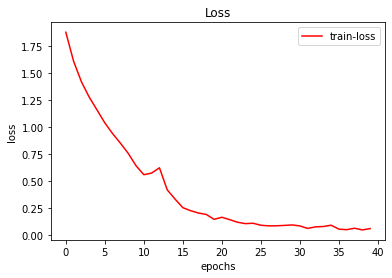

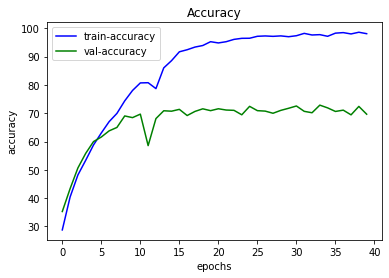

In [21]:
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 40
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)
# No se usa para entrenar!!!
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)



big_net =  MyNetBig(n_classes=10)
optimizer = optim.Adam(big_net.parameters(), lr=LR)


criterion = nn.CrossEntropyLoss()
train_loss_big_net, acc_big_net = train_for_classification(big_net, train_loader, val_loader, optimizer, criterion,  epochs=EPOCHS)
plot_results(train_loss_big_net, acc_big_net)

In [22]:
# Probemos en el conjunto de validacion:
x, y = list(test_loader)[0]
big_net.cpu()
big_net.eval()
y_pred = big_net(x).max(dim=1)[1]

print("Accuracy obtenida en el conjunto de TEST: {}".format((y==y_pred).sum()/len(x)))

Accuracy obtenida en el conjunto de TEST: 0.6875


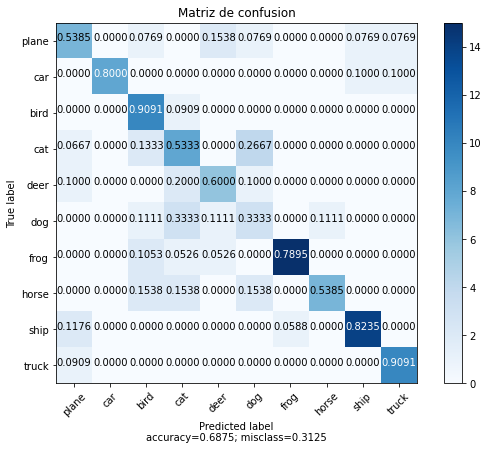

In [23]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes,title='Matriz de confusion')

# Entrenamiento SmallNet:

Epoch:1(10000/10000), Loss:1.58406, Train Acc:41.2%, Validating..., Val Acc:46.92%, Avg-Time:4.244s.
Epoch:2(10000/10000), Loss:1.26272, Train Acc:54.8%, Validating..., Val Acc:45.31%, Avg-Time:4.206s.
Epoch:3(10000/10000), Loss:1.15816, Train Acc:58.4%, Validating..., Val Acc:61.46%, Avg-Time:4.187s.
Epoch:4(10000/10000), Loss:0.88058, Train Acc:69.2%, Validating..., Val Acc:62.82%, Avg-Time:4.193s.
Epoch:5(10000/10000), Loss:0.68506, Train Acc:75.9%, Validating..., Val Acc:65.20%, Avg-Time:4.206s.
Epoch:6(10000/10000), Loss:0.53189, Train Acc:81.2%, Validating..., Val Acc:68.27%, Avg-Time:4.199s.
Epoch:7(10000/10000), Loss:0.40527, Train Acc:86.0%, Validating..., Val Acc:64.61%, Avg-Time:4.202s.
Epoch:8(10000/10000), Loss:0.26548, Train Acc:90.8%, Validating..., Val Acc:66.81%, Avg-Time:4.202s.
Epoch:9(10000/10000), Loss:0.18310, Train Acc:93.5%, Validating..., Val Acc:67.45%, Avg-Time:4.202s.
Epoch:10(10000/10000), Loss:0.12484, Train Acc:95.5%, Validating..., Val Acc:68.15%, Avg-Ti

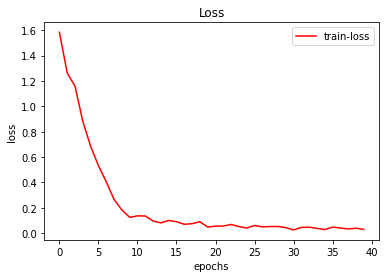

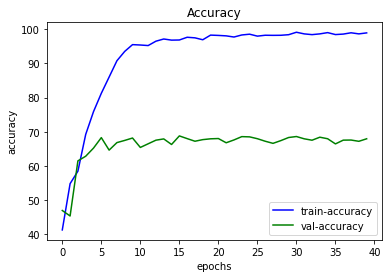

In [24]:
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 40
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)
# No se usa para entrenar!!!
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

small_net =  MyNetSmall(n_classes=10)
optimizer = optim.Adam(small_net.parameters(), lr=LR)


criterion = nn.CrossEntropyLoss()
train_loss, acc = train_for_classification(small_net, train_loader, val_loader, optimizer, criterion,  epochs=EPOCHS)
plot_results(train_loss, acc)

In [25]:
# Probemos en el conjunto de validacion:
x, y = list(test_loader)[0]
small_net.cpu()
small_net.eval()
y_pred = small_net(x).max(dim=1)[1]

print("Accuracy obtenida en el conjunto de TEST: {}".format((y==y_pred).sum()/len(x)))

Accuracy obtenida en el conjunto de TEST: 0.734375


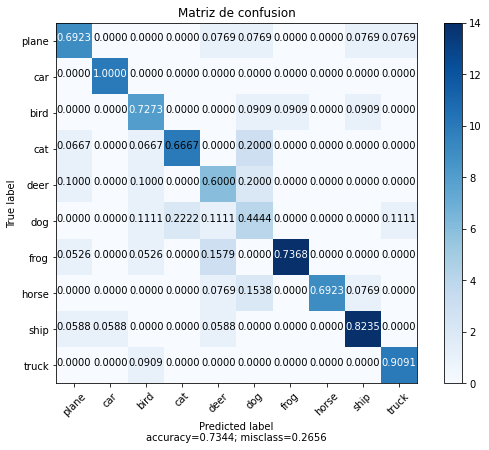

In [26]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes,title='Matriz de confusion')

# Data augmentation:
Se estudiara como afectan distintas transformaciones al dataset de entrenamiento, solo en la red pequena por temas de tiempo:

Epoch:1(10000/10000), Loss:1.62086, Train Acc:40.1%, Validating..., Val Acc:47.59%, Avg-Time:4.788s.
Epoch:2(10000/10000), Loss:1.28848, Train Acc:52.9%, Validating..., Val Acc:53.31%, Avg-Time:4.763s.
Epoch:3(10000/10000), Loss:1.10507, Train Acc:60.4%, Validating..., Val Acc:60.65%, Avg-Time:4.810s.
Epoch:4(10000/10000), Loss:0.95590, Train Acc:66.5%, Validating..., Val Acc:66.65%, Avg-Time:4.826s.
Epoch:5(10000/10000), Loss:0.92418, Train Acc:67.4%, Validating..., Val Acc:65.06%, Avg-Time:4.851s.
Epoch:6(10000/10000), Loss:0.88322, Train Acc:68.6%, Validating..., Val Acc:68.24%, Avg-Time:4.860s.
Epoch:7(10000/10000), Loss:1.09290, Train Acc:61.7%, Validating..., Val Acc:63.97%, Avg-Time:4.854s.
Epoch:8(10000/10000), Loss:0.77580, Train Acc:73.3%, Validating..., Val Acc:66.99%, Avg-Time:4.855s.
Epoch:9(10000/10000), Loss:0.66984, Train Acc:76.9%, Validating..., Val Acc:68.48%, Avg-Time:4.858s.
Epoch:10(10000/10000), Loss:0.55341, Train Acc:80.9%, Validating..., Val Acc:69.60%, Avg-Ti

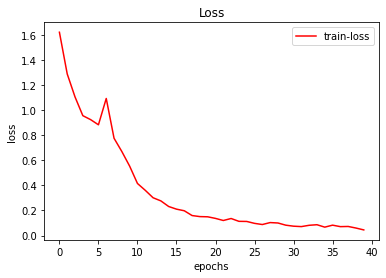

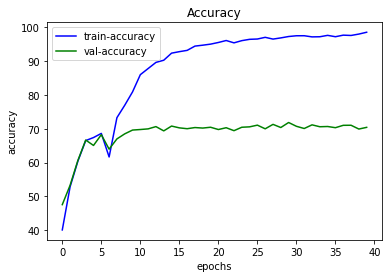

In [27]:
transform_aug = transforms.Compose([
    transforms.RandomCrop((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_aug = CIFAR10Train(transform=transform_aug)

BATCH_SIZE = 32
LR = 0.003
EPOCHS = 40
REPORTS_EVERY = 1

train_loader_aug = DataLoader(trainset_aug, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)
# No se usa para entrenar!!!
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

small_net_data_aug =  MyNetSmall(n_classes=10)
optimizer = optim.Adam(small_net_data_aug.parameters(), lr=LR)


criterion = nn.CrossEntropyLoss()
train_loss, acc = train_for_classification(small_net_data_aug, train_loader_aug, val_loader, optimizer, criterion,  epochs=EPOCHS)
plot_results(train_loss, acc)


In [28]:
# Validemos con la data:
x, y = list(test_loader)[0]
small_net_data_aug.cpu()
small_net_data_aug.eval()
y_pred = small_net_data_aug(x).max(dim=1)[1]

print("Accuracy obtenida en el conjunto de TEST: {}".format((y==y_pred).sum()/len(x)))

Accuracy obtenida en el conjunto de TEST: 0.6796875


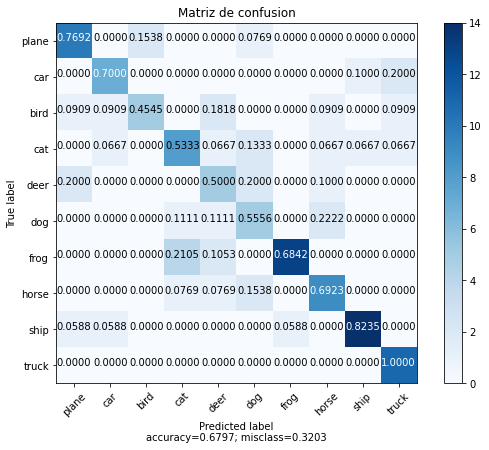

In [29]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes,title='Matriz de confusion')

# Prueba en ambas redes con el dataset completo de entrenamiento:
Para observar la capacidad real de cada red, se pasara el dataset completo de entrenamiento (`['data_batch_1', 'data_batch_3', 'data_batch_4', 'data_batch_5']`) por solo 10 epocas para ver el resultado:

In [30]:
trainset_completo = CIFAR10Train(transform=transform, dataset_completo = True)

Epoch:1(40000/40000), Loss:1.57685, Train Acc:42.0%, Validating..., Val Acc:54.98%, Avg-Time:26.262s.
Epoch:2(40000/40000), Loss:1.09881, Train Acc:61.4%, Validating..., Val Acc:67.05%, Avg-Time:26.384s.
Epoch:3(40000/40000), Loss:0.86255, Train Acc:70.4%, Validating..., Val Acc:73.57%, Avg-Time:26.343s.
Epoch:4(40000/40000), Loss:0.70220, Train Acc:76.6%, Validating..., Val Acc:78.13%, Avg-Time:26.382s.
Epoch:5(40000/40000), Loss:0.57231, Train Acc:81.1%, Validating..., Val Acc:79.04%, Avg-Time:26.362s.
Epoch:6(40000/40000), Loss:0.47034, Train Acc:84.4%, Validating..., Val Acc:79.64%, Avg-Time:26.382s.
Epoch:7(40000/40000), Loss:0.38847, Train Acc:87.2%, Validating..., Val Acc:81.14%, Avg-Time:26.405s.
Epoch:8(40000/40000), Loss:0.30255, Train Acc:90.0%, Validating..., Val Acc:81.41%, Avg-Time:26.426s.
Epoch:9(40000/40000), Loss:0.23025, Train Acc:92.4%, Validating..., Val Acc:81.79%, Avg-Time:26.448s.
Epoch:10(40000/40000), Loss:0.17936, Train Acc:94.1%, Validating..., Val Acc:82.24

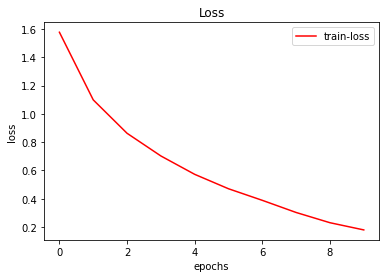

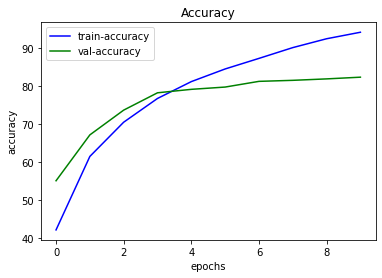

In [31]:
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 10
REPORTS_EVERY = 1

train_loader = DataLoader(trainset_completo, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)
# No se usa para entrenar!!!
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

big_net_complete_dataset =  MyNetBig(n_classes=10)
optimizer = optim.Adam(big_net_complete_dataset.parameters(), lr=LR)


criterion = nn.CrossEntropyLoss()
train_loss_big_net_complete_dataset, acc_big_net_complete_dataset = train_for_classification(big_net_complete_dataset, train_loader, val_loader, optimizer, criterion,  epochs=EPOCHS)
plot_results(train_loss_big_net_complete_dataset, acc_big_net_complete_dataset)

In [32]:
# Probemos en el conjunto de validacion:
x, y = list(test_loader)[0]
big_net_complete_dataset.cpu()
big_net_complete_dataset.eval()
y_pred = big_net_complete_dataset(x).max(dim=1)[1]

print("Accuracy obtenida en el conjunto de TEST: {}".format((y==y_pred).sum()/len(x)))

Accuracy obtenida en el conjunto de TEST: 0.8515625


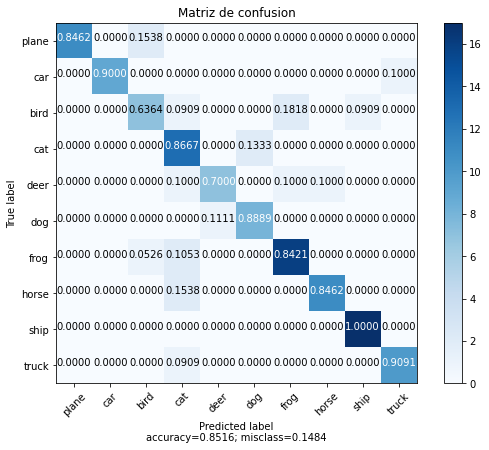

In [33]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes,title='Matriz de confusion')

Epoch:1(40000/40000), Loss:1.26595, Train Acc:54.2%, Validating..., Val Acc:67.59%, Avg-Time:16.452s.
Epoch:2(40000/40000), Loss:0.82936, Train Acc:71.3%, Validating..., Val Acc:73.63%, Avg-Time:16.540s.
Epoch:3(40000/40000), Loss:0.89500, Train Acc:68.5%, Validating..., Val Acc:73.75%, Avg-Time:16.676s.
Epoch:4(40000/40000), Loss:0.59285, Train Acc:79.4%, Validating..., Val Acc:77.43%, Avg-Time:16.715s.
Epoch:5(40000/40000), Loss:0.46177, Train Acc:84.0%, Validating..., Val Acc:76.15%, Avg-Time:16.719s.
Epoch:6(40000/40000), Loss:0.35005, Train Acc:87.9%, Validating..., Val Acc:78.27%, Avg-Time:16.721s.
Epoch:7(40000/40000), Loss:0.28088, Train Acc:90.1%, Validating..., Val Acc:78.16%, Avg-Time:16.744s.
Epoch:8(40000/40000), Loss:0.19794, Train Acc:93.0%, Validating..., Val Acc:78.27%, Avg-Time:16.746s.
Epoch:9(40000/40000), Loss:0.15297, Train Acc:94.7%, Validating..., Val Acc:78.72%, Avg-Time:16.744s.
Epoch:10(40000/40000), Loss:0.13452, Train Acc:95.3%, Validating..., Val Acc:78.56

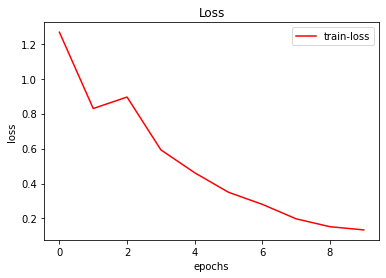

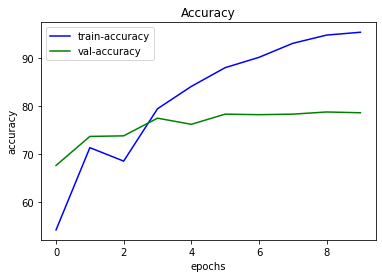

In [34]:
# Red pequena:
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 10
REPORTS_EVERY = 1

train_loader = DataLoader(trainset_completo, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)
# No se usa para entrenar!!!
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

small_net_complete_dataset =  MyNetSmall(n_classes=10)
optimizer = optim.Adam(small_net_complete_dataset.parameters(), lr=LR)


criterion = nn.CrossEntropyLoss()
train_loss, acc = train_for_classification(small_net_complete_dataset, train_loader, val_loader, optimizer, criterion,  epochs=EPOCHS)
plot_results(train_loss, acc)

In [35]:
# Probemos en el conjunto de validacion:
x, y = list(test_loader)[0]
small_net_complete_dataset.cpu()
small_net_complete_dataset.eval()
y_pred = small_net_complete_dataset(x).max(dim=1)[1]

print("Accuracy obtenida en el conjunto de TEST: {}".format((y==y_pred).sum()/len(x)))

Accuracy obtenida en el conjunto de TEST: 0.7890625


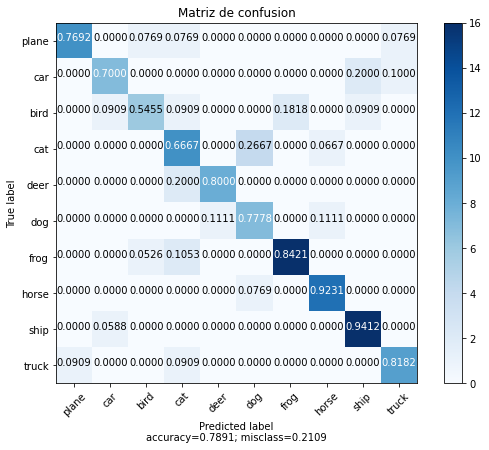

In [36]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes,title='Matriz de confusion')

## Conclusiones:

- En primer lugar, se comprendio como utilizar `Pytorch` para implementar DataSets y Dataloaders, tambien distintas arquitecturas de redes convolucionales con sub modulos o bloques. 
- Se comprendio como afecta el tamano del test de entrenamiento: hay una clara mejoria al utilizar el dataset completo. 
- Tambien se realizo un experimento para comprobar el efecto de realizar data augmentation en el conjunto de test. Los resultados obtenidos variaron dependiendo de la ejecucion. En ocaciones, el resultado era mejor y en otras no. De todas formas, permite que la red generalice de mejor forma. 
